# Обработка результатов A/B эксперимента по рекомендации постов пользователям.

Ранее был написан код для экспериментирования с двумя моделями в нашем сервисе. Этот код вместе с рекомендациями возвращает группу, в которую попал пользователь.  
Представим, что мы проводили этот эксперимент на пользователях в течение 2 недель. В результаты мы получили сырые данные об эксперименте, которые будут обработаны этой работе.  
__Таблица likes__ - данные о лайках пользователей.  
__Таблица views__ - данные о просмотрах пользователей.  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import binomtest
from scipy.stats import mannwhitneyu
import hashlib

In [2]:
likes = pd.read_csv(r'/kaggle/input/karpov-ab-test-result/likes.csv')
views = pd.read_csv(r'/kaggle/input/karpov-ab-test-result/views.csv')

In [3]:
likes.head()

,user_id,post_id,timestamp
0,128381,4704,1654030804
1,146885,1399,1654030816
2,50948,2315,1654030828
3,14661,673,1654030831
4,37703,1588,1654030833


In [4]:
views.head()

,user_id,exp_group,recommendations,timestamp
0,128381,control,[3644 4529 4704 5294 4808],1654030803
1,146885,test,[1399 1076 797 7015 5942],1654030811
2,50948,test,[2315 3037 1861 6567 4093],1654030825
3,37703,test,[2842 1949 162 1588 6794],1654030826
4,14661,test,[2395 5881 5648 3417 673],1654030829


In [5]:
views.exp_group.value_counts()

test       96917
control    96378
Name: exp_group, dtype: int64

В обоих группах, примерно одинаковое число просмотров постов. Проверим, нет ли у нас пользователей, которые попали в обе группы. Если их совсем немного, то удалим их из обеих выборок.

In [6]:
control = set(views[views.exp_group == 'control']['user_id'].unique())
test = set(views[views.exp_group == 'test']['user_id'].unique())
control_test = control.intersection(test)

Просмотры пользователей, которые попали в обе группы control и test.

In [7]:
views[views.user_id.isin(control_test)]

,user_id,exp_group,recommendations,timestamp
1311,148670,test,[2992 1368 1261 3901 4471],1654039282
6179,142283,control,[1109 101 5288 4941 132],1654069529
29724,148670,test,[5053 1563 7194 633 1392],1654217190
30748,148670,test,[7128 1023 1388 6807 5945],1654223589
39653,55788,test,[3747 6638 5214 2801 5740],1654279384
39787,25623,test,[1529 6456 1549 4870 4651],1654280154
41040,148670,test,[1866 622 4374 3756 5424],1654288069
45925,142283,control,[4181 3410 751 1880 1682],1654318631
46348,142283,test,[6484 611 395 5678 7295],1654321430
82515,55788,control,[4970 2990 4592 6611 5483],1654545938


Лайки сделанные этими пользователями.

In [8]:
likes[likes.user_id.isin(control_test)]

,user_id,post_id,timestamp
1438,148670,2992,1654039320
1577,148670,1368,1654040074
7177,142283,132,1654069531
35765,148670,633,1654220670
36280,148670,1388,1654223590
36284,148670,6807,1654223593
36295,148670,5945,1654223616
36297,148670,7128,1654223621
46888,55788,3747,1654279385
47066,25623,4870,1654280155


Пользователи, которые попали в обе группы.

In [9]:
control_test

{25623, 55788, 142283, 148670}

Всего 4 пользователя. Удалим их.

In [10]:
views = views[~views.user_id.isin(control_test)]
likes = likes[~likes.user_id.isin(control_test)]

Проверим число просмотров.

In [11]:
views.exp_group.value_counts()

test       96898
control    96370
Name: exp_group, dtype: int64

Проверим в таблице views число пользователей в каждой группе.

In [12]:
views.groupby('user_id').first().exp_group.value_counts()

test       32659
control    32350
Name: exp_group, dtype: int64

In [13]:
views.groupby('user_id').first().exp_group.value_counts(normalize='True')

test       0.502377
control    0.497623
Name: exp_group, dtype: float64

В обоих группах примерно одинаковое число пользователей. Применим критерий для долей (биномиальный тест), чтобы проверить соответствие этой доли группы test ожидаемым 0.5.

In [14]:
N_test  = views.groupby('user_id').first().exp_group.value_counts().test
N = views.groupby('user_id').first().exp_group.count()

In [15]:
proportion_confint(N_test, N, alpha=0.05, method='normal')

(0.49853309789386646, 0.5062200901262539)

95-процентный доверительный интервал значения доли тестовой группы составляет от 0.4985 до 0.5052, что довольно близко к значению 0.5.

In [16]:
binomtest(k=N_test, n=N, p=0.5)

BinomTestResult(k=32659, n=65009, alternative='two-sided', proportion_estimate=0.5023765940100602, pvalue=0.2270501563614752)

Принимаем нулевую гипотезу, что группы имеют биноминальное распределение с вероятностью 0.5.

## Подсчёт количества лайков пользователей.

Соберём таблицу, в которой будут пользователи, попавшие в наш эксперимент (т. е. те, для которых мы строили хотя бы одну рекомендацию). Посчитаем, кто из них сколько лайков сделал. Возможно будут пользователи, которые не сделали ни один лайк. 
Подсчитаем долю пользователей, которая сделала хотя бы один лайк за время эксперимента без разбивки на группы.

In [17]:
# Таблица соотнесения пользователя к экспериментальной группе.
groups = views.groupby('user_id').first().reset_index()[['user_id', 'exp_group']]

In [18]:
groups

,user_id,exp_group
0,200,test
1,201,test
2,202,test
3,212,test
4,213,test
...,...,...
65004,168538,test
65005,168541,control
65006,168544,test
65007,168545,test


Число лайков каждого пользователя, во время проведения эксперимента.

In [19]:
users_likes = likes.groupby('user_id').post_id.count().reset_index().rename(columns={'post_id': 'like_num'})

In [20]:
users_likes

,user_id,like_num
0,200,1
1,201,3
2,202,2
3,212,4
4,213,7
...,...,...
58162,168525,2
58163,168532,4
58164,168538,5
58165,168541,2


Соединим с таблицей пользователь-группа.
Отсутствующие значения означают, что пользователь не делал лайков, заполним их нулями.

In [21]:
group_likes = pd.merge(groups, users_likes, on='user_id', how='left')
group_likes.like_num = group_likes.like_num.fillna(0)

In [22]:
group_likes

,user_id,exp_group,like_num
0,200,test,1.0
1,201,test,3.0
2,202,test,2.0
3,212,test,4.0
4,213,test,7.0
...,...,...,...
65004,168538,test,5.0
65005,168541,control,2.0
65006,168544,test,0.0
65007,168545,test,5.0


Пользователь сделал хоть один лайк?

In [23]:
group_likes['has_like'] = (group_likes['like_num'] > 0).astype(int)

In [24]:
group_likes

,user_id,exp_group,like_num,has_like
0,200,test,1.0,1
1,201,test,3.0,1
2,202,test,2.0,1
3,212,test,4.0,1
4,213,test,7.0,1
...,...,...,...,...
65004,168538,test,5.0,1
65005,168541,control,2.0,1
65006,168544,test,0.0,0
65007,168545,test,5.0,1


Доля всех пользователей сделавших хоть один лайк, без разбивки на группы.

In [25]:
group_likes.has_like.mean()

0.8947530341952653

Доля всех пользователей сделавших хоть один лайк, в пределах каждой группы.

In [26]:
sum_group_likes = group_likes.groupby('exp_group')[['has_like', 'like_num']].mean()
sum_group_likes

,has_like,like_num
exp_group,,
control,0.891314,3.487079
test,0.898160,3.592578


## Оценим, различаются ли число лайков между группами.

Число кликов на пользователя распределено логнормально, если его визуализировать. Поэтому применим непараметрический критерии Манна-Уитни-Уилкоксона к числу лайков каждого пользователя.

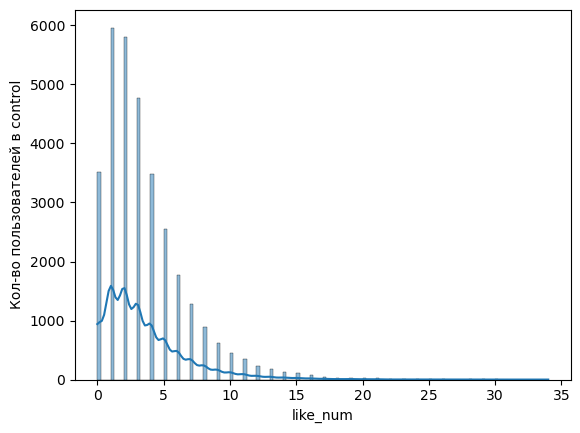

In [27]:
p = sns.histplot(group_likes[group_likes.exp_group == 'control'].like_num, kde=True)
p.set(ylabel = 'Кол-во пользователей в control')
plt.show()

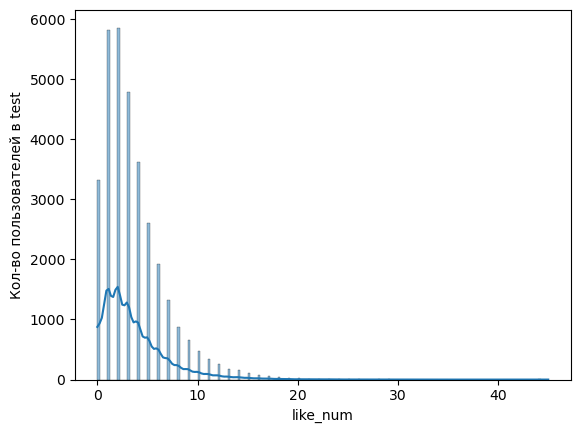

In [28]:
p = sns.histplot(group_likes[group_likes.exp_group == 'test'].like_num, kde=True)
p.set(ylabel = 'Кол-во пользователей в test')
plt.show()

Число лайков каждого пользователя для разных групп.

In [29]:
group_likes[group_likes.exp_group == 'control'].like_num

6        4.0
7        5.0
9        3.0
10       3.0
11       4.0
        ... 
64999    0.0
65001    2.0
65002    0.0
65005    2.0
65008    0.0
Name: like_num, Length: 32350, dtype: float64

In [30]:
group_likes[group_likes.exp_group == 'test'].like_num

0        1.0
1        3.0
2        2.0
3        4.0
4        7.0
        ... 
65000    3.0
65003    4.0
65004    5.0
65006    0.0
65007    5.0
Name: like_num, Length: 32659, dtype: float64

In [31]:
mannwhitneyu(
    group_likes[group_likes.exp_group == 'control'].like_num,
    group_likes[group_likes.exp_group == 'test'].like_num,
)

MannwhitneyuResult(statistic=518358073.0, pvalue=2.9585062792441964e-05)

Отвергаем нулевую гипотезу, что значимых изменений в группах нет.

Доля пользователей, которые поставили хоть один лайк.

In [32]:
sum_group_likes

,has_like,like_num
exp_group,,
control,0.891314,3.487079
test,0.898160,3.592578


В группе test увеличилась доля пользователей, которая поставила хоть один лайк и среднее кол-во лайков.

## Подсчёт метрики Hitrate@5.

Соединим слева таблицу views с таблицей likes, по полю user_id. Значения NaN заполним -1. Значения NaN будут означать, что после нашей рекомендации пользователь не поставил лайк ни одному посту или пара рекомендация - пост не имеет смысла, например, когда время проставления лайка меньше времени рекомендации.

In [33]:
views_likes = pd.merge(views, likes, on='user_id', how='left')
views_likes.post_id = views_likes.post_id.fillna(-1).astype(int)

Распарсим рекомендации из строки в список.

In [34]:
views_likes['recommendations'] = views_likes.recommendations.apply(
    lambda x: list(map(int, filter(bool, x[1:-1].split(' '))))
)

In [35]:
views_likes

,user_id,exp_group,recommendations,timestamp_x,post_id,timestamp_y
0,128381,control,"[3644, 4529, 4704, 5294, 4808]",1654030803,4704,1.654031e+09
1,128381,control,"[3644, 4529, 4704, 5294, 4808]",1654030803,5294,1.654031e+09
2,128381,control,"[3644, 4529, 4704, 5294, 4808]",1654030803,3608,1.655049e+09
3,128381,control,"[3644, 4529, 4704, 5294, 4808]",1654030803,2542,1.655049e+09
4,128381,control,"[3644, 4529, 4704, 5294, 4808]",1654030803,4165,1.655053e+09
...,...,...,...,...,...,...
1016884,52169,test,"[1368, 1709, 1616, 798, 5305]",1655240354,1709,1.655240e+09
1016885,142402,test,"[5895, 6984, 1978, 6548, 6106]",1655240373,6548,1.655240e+09
1016886,72259,control,"[6117, 1255, 6567, 3587, 3811]",1655240388,1712,1.654305e+09
1016887,72259,control,"[6117, 1255, 6567, 3587, 3811]",1655240388,5070,1.654309e+09


post_id - это id поста, которому пользователь поставил лайк. Пометим это поле -1 для следующих случаев:   
* если значение post_id == -1;  
* если время рекомендации больше, чем время лайка;  
* если лайк поста был больше, чем через час, после рекомендаций;  
* если лайкнутого поста нет в рекомендациях.


In [36]:
views_likes.post_id = views_likes.apply(
    lambda row:
    -1
    if
        (row.post_id == -1) | 
        ((row.timestamp_x > row.timestamp_y) |
         (row.timestamp_x + 60 * 60 < row.timestamp_y)) |
        (row.post_id not in row.recommendations)
    else
    row.post_id, axis=1)

Проверим размерности таблиц.

In [37]:
len(views), len(views_likes)

(193268, 1016889)

In [38]:
views_likes.groupby(['user_id', 'timestamp_x']).first().shape

(193268, 4)

Напишем специальную агрегирующую функцию для post_id и сгруппируем по user_id, exp_group, timestamp_x. Для групп post_id функция будет возвращать 1 если:  
* значение post_id == -1 содержится среди уникальных значений группы, в которой два и более элемента (т.е. пользователь лайкнул, хотя бы один пост из рекомендаций);
* в группе уникальных значений post_id нет значения -1.  

Т.е. значение 1 означает, что пользователь лайкнул хоть один пост из наших рекомендаций.

In [39]:
def my_agg(values):
    values = set(values)
    if -1 in values and len(values) >= 2:
        return 1
    elif -1 not in values:
        return 1
    return 0

tmp_agg = views_likes.groupby(['user_id', 'exp_group', 'timestamp_x']).post_id.agg(my_agg)

In [40]:
tmp_agg

user_id  exp_group  timestamp_x
200      test       1655009047     1
201      test       1654043283     0
                    1654173790     0
                    1654444704     1
                    1654517459     0
                                  ..
168545   test       1654295281     1
                    1654412184     1
                    1654887207     1
168552   control    1654516294     0
                    1654885693     0
Name: post_id, Length: 193268, dtype: int64

Итоговое значение метрики Hitrate@5:

In [41]:
tmp_agg.reset_index().post_id.mean()

0.7132582734855227

### Оценка различий между группами.

z-критерий для долей мы здесь не можем применять, так как у нас в каждой выборке один и тот же пользователь может встречаться несколько раз. Будем применять бакетный подход (то есть перейдём к бакетам и по ним оценим значимость), чтобы подсчитать групповой hitrate (или CTR) — доля hitrate по группе/бакету. Будем использовать 100 бакетов. Уровень значимости останется тем же на уровне 0.05.

In [42]:
tmp_agg = tmp_agg.reset_index().rename(columns={'post_id': 'hitrate'})

In [43]:
import hashlib

tmp_agg['bucket'] = tmp_agg['user_id'].apply(
    lambda x: int(hashlib.md5((str(x) + 'my_salt').encode()).hexdigest(), 16) % 100
)

In [44]:
tmp_agg['view'] = 1

new_df = tmp_agg.groupby(['exp_group', 'bucket']).sum(['hitrate', 'view']).reset_index()
new_df['hitrate_bucket'] = new_df.hitrate / new_df.view

new_df.head()

,exp_group,bucket,user_id,timestamp_x,hitrate,view,hitrate_bucket
0,control,0,77778737,1507360555437,635,911,0.697036
1,control,1,82853383,1525568975208,652,922,0.707158
2,control,2,96371589,1712551288046,741,1035,0.715942
3,control,3,81600187,1523924283634,682,921,0.740499
4,control,4,77182250,1570243133349,664,949,0.699684


In [45]:
tmp_agg.groupby('exp_group').hitrate.mean()

exp_group
control    0.706651
test       0.719829
Name: hitrate, dtype: float64

In [46]:
from scipy.stats import mannwhitneyu, ttest_ind

In [47]:
mannwhitneyu(
    new_df[new_df.exp_group == 'control'].hitrate_bucket,
    new_df[new_df.exp_group == 'test'].hitrate_bucket,
)

MannwhitneyuResult(statistic=2750.0, pvalue=3.876018970118259e-08)

In [48]:
ttest_ind(
    new_df[new_df.exp_group == 'control'].hitrate_bucket,
    new_df[new_df.exp_group == 'test'].hitrate_bucket,
)

Ttest_indResult(statistic=-5.790457073344514, pvalue=2.7195475906984277e-08)

Значимые изменения. Средние в группах не равны. Метрика Hitrate@5 улучшилась. Вторая модель делает более эффективные рекомендации.